In [9]:
import matplotlib as mpl

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'text.usetex': True,
    'font.family': "serif",
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": True,
    'figure.figsize': (16,24), 
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# it probably has something to do with python versions or something
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes (but not on all machines)
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')
# the gray border is not visible in the plot rendered
# by plt.savefig, so dont't  worry about that

# finally change the necessary parameters
plt.rcParams.update(newparams)

# pretty-print sympy things
sp.init_printing()

In [2]:
import scipy as scp
import scipy.constants as const
k_B = const.Boltzmann

Det er oppgitt at $k\beta$ er mellom $3$ og $5$.

In [14]:
temp = 273 + 20 # Kelvin
beta = 1 / (k_B * temp)
Cc = 0.07 # membrane capacitance

h = 1
L = 50

def P_r(xs, V):
    rs = np.zeros(xs.shape)
    for i, x in enumerate(xs):
        rs[i] = np.exp(-beta * (V(x - h) - V(x + h)))
    return 1 / (1 + rs)

def steps(xs, V):
    rng = np.random.random(xs.shape)
    return h * np.where(rng < P_r(xs, V), 1, -1)

Gitt $x$-verdiane kan vi beregne alle $P_R(x)$-verdiane.
Desse verdiane brukar vi for å ta steg tilfeldig.

## Potensial
Vi er nødde til å superposisjonere fleire potensial i denne oppgåva,
ettersom vi arbeider med eit konstant membranpotensiale,
og eit varierande elektrisk felt på grunna av spenningsforskjellen.

In [28]:
# menbrane-potentials
V0_Na = 1  / beta
V0_K  = 10 / beta

def Vmem_Na(x):
    if abs(x) > L / 2:
        return np.inf
    if -h <= x <= h:
        return V0_Na
    else:
        return 0
    
def Vmem_K(x):
    if abs(x) > L / 2:
        return np.inf
    elif -h <= x <= h:
        return V0_K
    else:
        return 0
    
def lerp(x, y, t): return (1 - t) * x + t * y
    
def Vfield(x, voltage):
    if x < -h:
        return voltage * const.elementary_charge
    elif x > h:
        return 0
    else:
        return lerp(voltage, 0, (x + h)/2) * const.elementary_charge

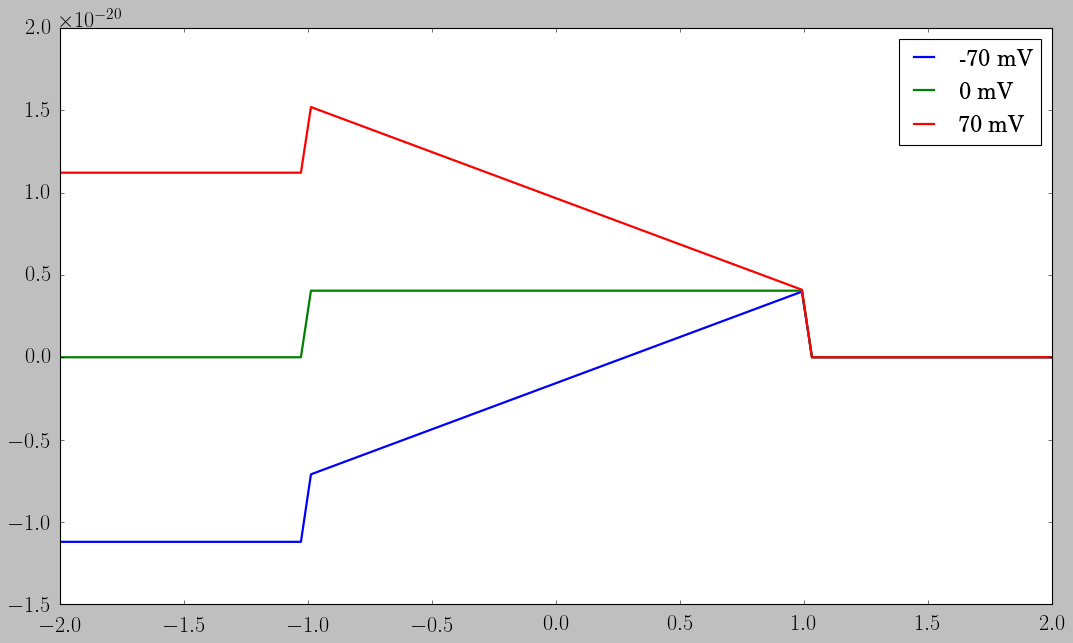

In [29]:
ts = np.linspace(-2, 2, 100)
ys = np.empty((100,3))
for y, t in enumerate(ts):
    ys[y, 0] = Vmem_Na(t) + Vfield(t, -70*1e-3)
    ys[y, 1] = Vmem_Na(t) + Vfield(t, 0)
    ys[y, 2] = Vmem_Na(t) + Vfield(t, 70*1e-3)
    
plt.figure(figsize=(16, 9))
plt.plot(ts, ys[:, 0], label='-70 mV');
plt.plot(ts, ys[:, 1], label='  0 mV');
plt.plot(ts, ys[:, 2], label=' 70 mV');
plt.legend(loc='upper right');

## Simulasjon

In [30]:
## starttilstand.          ute   inne
Na_outside, Na_inside =   1450,    50
K_outside,  K_inside  =     50,  1400

N_Na = Na_outside + Na_inside
Na = np.array([ L/4 for _ in range(Na_outside)]  \
            + [-L/4 for _ in range(Na_inside) ])


N_K = K_outside + K_inside
K  = np.array([ L/4 for _ in range(K_outside)]   \
            + [-L/4 for _ in range(K_inside) ])

phi_K, phi_Na = dict(),  dict()

## simulasjon
# start parameters: T = #steps
plot_ts = [5, 50, 150, 1000, 2500]
T = max(plot_ts)

# voltage for each t
Vs = np.zeros(T + 1)
# count particles inside for each t 
Ks_inside  = np.zeros(T + 1)
Nas_inside = np.zeros(T + 1)

for t in range(T + 1):
    # count the particles inside the cell
    # we are strict, and don't count particles
    # "in the membrane" as inside the cell
    count_K  = len(K[np.where(K < -h)])
    count_Na = len(Na[np.where(Na < -h)])
    
    # compute charge concentration difference
    charge_conc = (count_K + count_Na) * 0.1 # mM
    charge_delta = (charge_conc - 150) # concentration is 150 mM outside
    
    # compute voltage (in volts, not millivolts)
    voltage = 1e-3 * charge_delta / Cc
    Vs[t] = voltage
    
    # compute steps with superposisioned potentials
    K  += steps(K,  lambda x: Vmem_K(x)  + Vfield(x, voltage))
    Na += steps(Na, lambda x: Vmem_Na(x) + Vfield(x, voltage))
    
    # save the data
    Ks_inside[t] = count_K
    Nas_inside[t] = count_Na
    if t in plot_ts:
        phi_K[t]  = np.copy(K)
        phi_Na[t] = np.copy(Na)

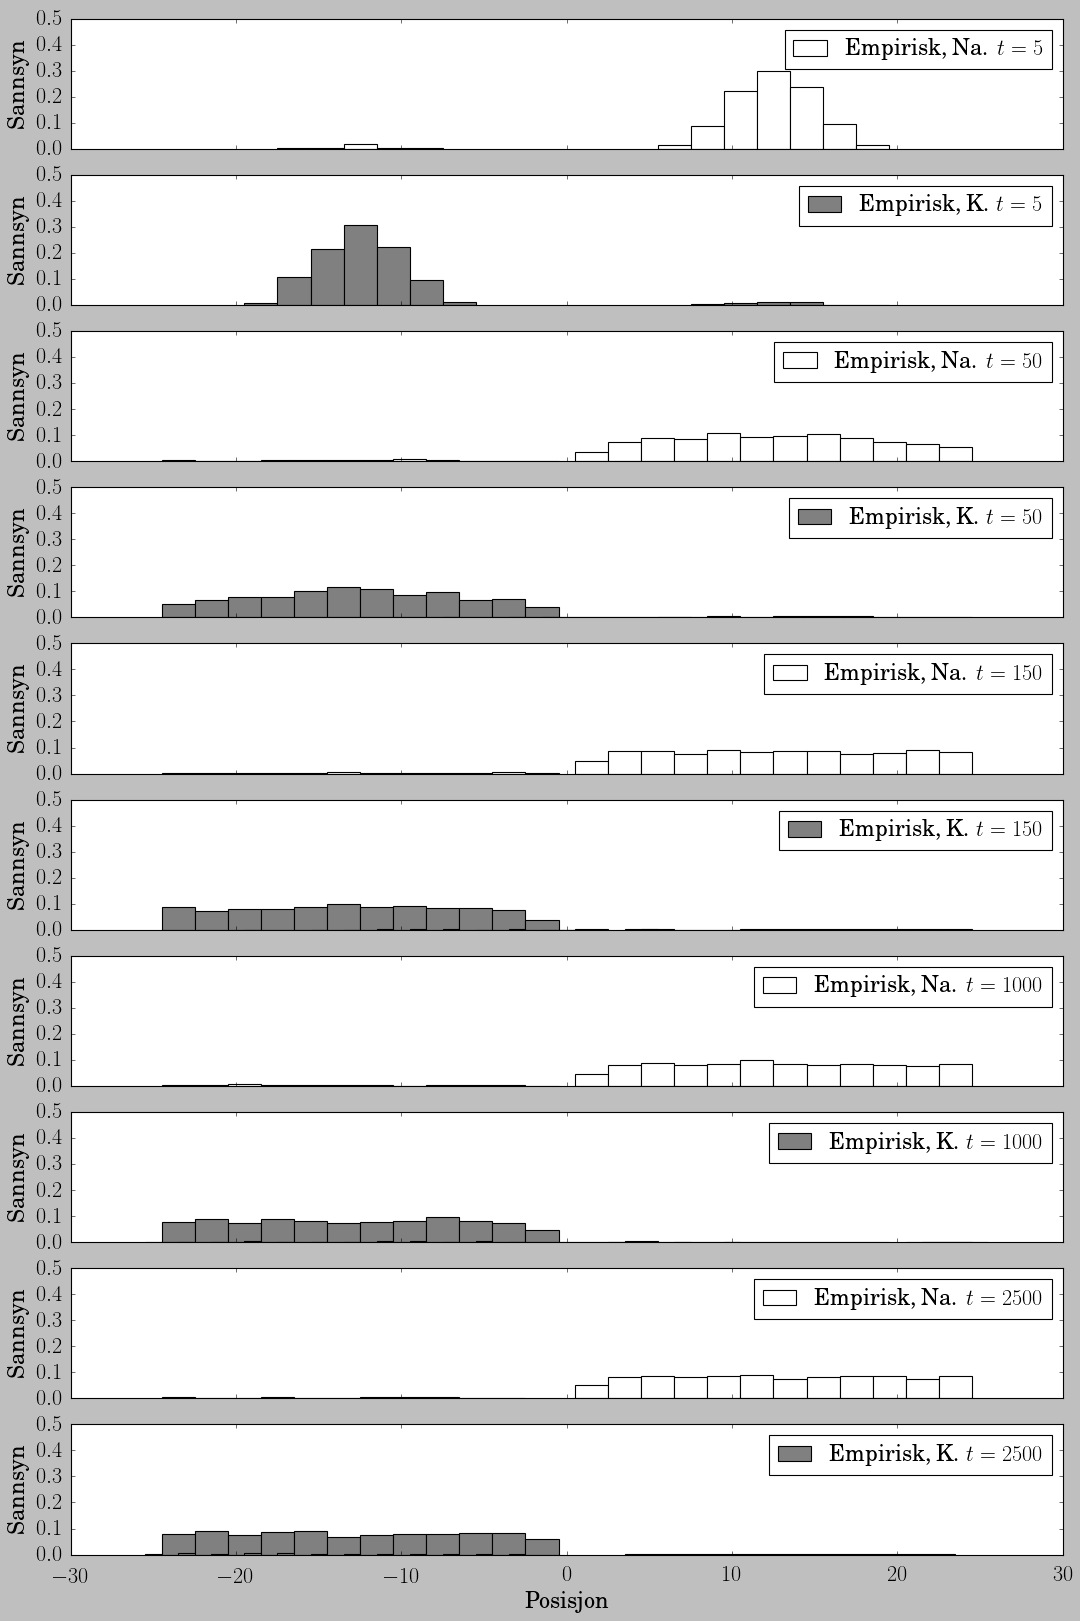

In [18]:
fig = plt.figure()
axes = fig.subplots(2*len(plot_ts), 1, sharex=True)

ylim = (0, .5)

### plot 1
for i, t in zip(range(0, 2*len(plot_ts), 2), plot_ts):
    unique_Na, count_Na = np.unique(phi_Na[t], return_counts=True)
    unique_K,  count_K  = np.unique(phi_K[t],  return_counts=True)
    axes[i].bar(
        unique_Na, count_Na / N_Na,
        edgecolor="black",
        color='white',
        width=h*2,
        align='center',
        label='Empirisk, Na. $t = {}$'.format(t),
    )
    
    axes[i+1].bar(
        unique_K, count_K / N_K,
        edgecolor="black",
        color='gray',
        width=h*2,
        align='center',
        label='Empirisk, K. $t = {}$'.format(t),
    )

    axes[i].set_ylim(*ylim)
    axes[i].set_ylabel(r"Sannsyn")  
    axes[i].legend(loc='upper right')
    axes[i+1].set_ylim(*ylim)
    axes[i+1].set_ylabel(r"Sannsyn")  
    axes[i+1].legend(loc='upper right')

plt.xlabel(r"Posisjon")

plt.savefig("walk_7_1.pdf")

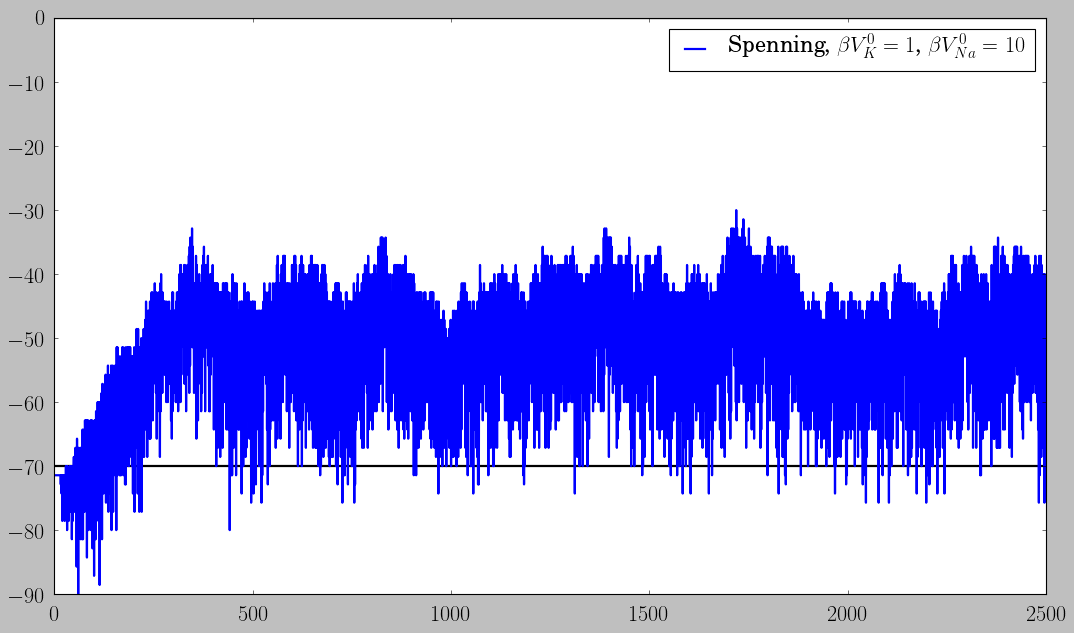

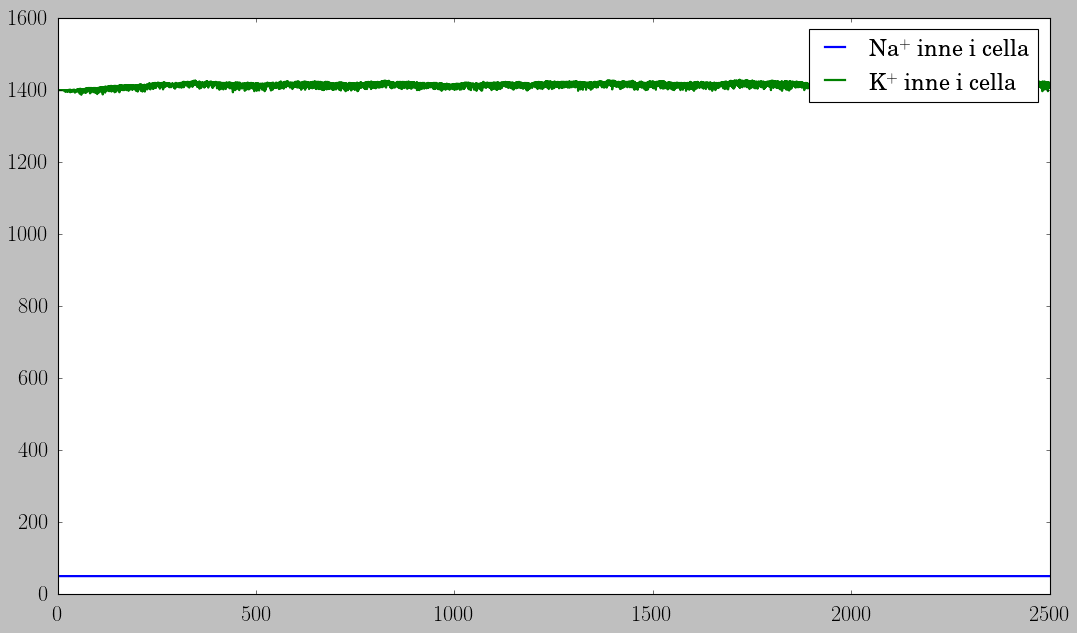

In [19]:
fig=plt.figure(figsize=(16, 9))
plt.plot(np.arange(T+1), 1e3 * Vs,   label=r"Spenning, $\beta V_K^0 = 1$, $\beta V_{Na}^0 = 10$")
plt.legend()
plt.hlines(-70, 0, T+1)
plt.hlines(0, 0, T+1)
plt.xlim(0, T+1)
plt.savefig("volt_bVK1_bVNa10.pdf")

fig=plt.figure(figsize=(16, 9))
plt.plot(np.arange(T+1), Nas_inside, label="Na$^+$ inne i cella")

plt.plot(np.arange(T+1), Ks_inside,  label="K$^+$ inne i cella")
plt.legend();

In [21]:
def avg_subintervals(A, n):
    D = n * (len(A) // n)
    return np.mean(A[:D].reshape(-1, n), axis=1)

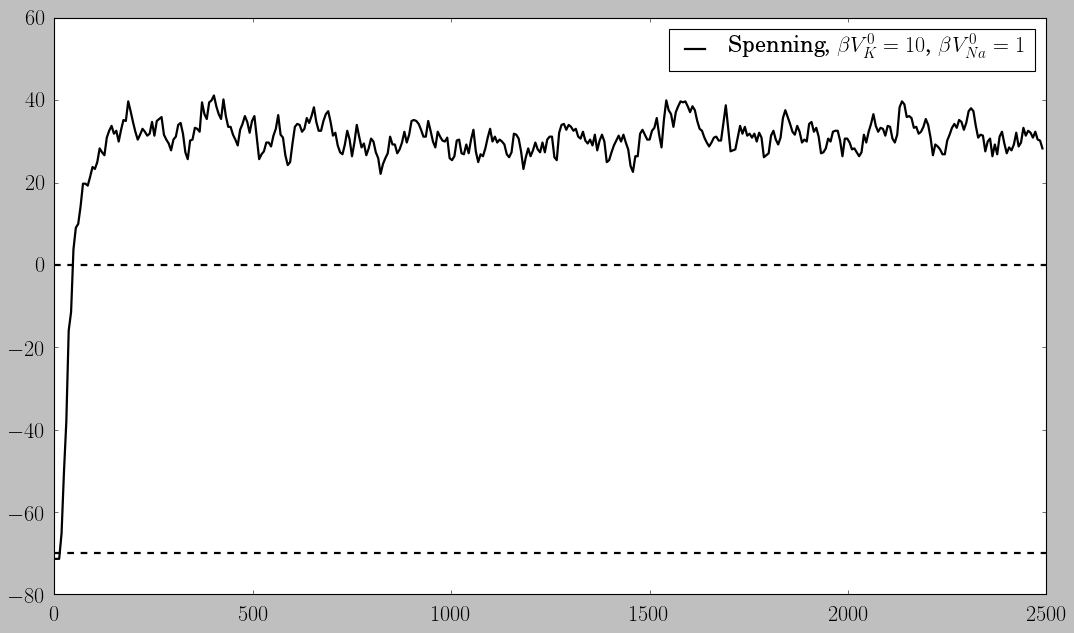

In [32]:
plt.figure(figsize=(16, 9))

n_avg = 6
A = avg_subintervals(Vs, n_avg)

plt.plot(
    n_avg*np.arange(0, len(A)),
    1e3 * A, # convert to mV
    'k-',
    label=r"Spenning, $\beta V_K^0 = 10$, $\beta V_{Na}^0 = 1$",
)

plt.savefig('volt72_Na1K10.pdf', bbox_inches = 'tight', pad_inches = 0)

plt.legend()
plt.hlines(-70, 0, T+1, linestyles='dashed')
plt.hlines(0, 0, T+1, linestyles='dashed')

plt.xlim(0, T)